<a href="https://colab.research.google.com/github/erilycus/Advanced-Cybersecurity-Lab/blob/main/Food_Vison_prod_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

We are trying to impement an AI Object Detection System that can
1. Identify multiple food items on a plate under different lighting conditions.
2. Create segmentation masks.
3. Predict the food item and estimate portion size.

## 0. Setting Up Platform

Setting up the platform with updated libraries and device agonistic code.

### Installing necessary Packages

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
from torch import nn
from packaging import version
import torchvision

required_torch = "1.12.0"
required_torchvision = "0.13.0"

if version.parse(torch.__version__) < version.parse(required_torch) or \
   version.parse(torchvision.__version__) < version.parse(required_torchvision):
    print("[INFO] torch/torchvision versions not as required, installing latest versions.")
    # You can change cu121 to cu118 or cpu as needed
    import os
    os.system("pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    # Reload torch and torchvision to reflect new versions
    import importlib
    importlib.reload(torch)
    importlib.reload(torchvision)

print(f"✅ torch version: {torch.__version__}")
print(f"✅ torchvision version: {torchvision.__version__}")

✅ torch version: 2.8.0+cu126
✅ torchvision version: 0.23.0+cu126


And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> Change runtime type -> Hardware accelerator -> GPU. **If you do this, your runtime will likely reset and you'll have to run all of the cells above by going Runtime -> Run before.**

If you are running on a CPU-only machine, please use `torch.load()` with `map_location=torch.device('cpu')` to map your storages to the **CPU**.

### Setting up Device

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup Number of CPU Workers
import os
num_workers = os.cpu_count()
print(f"✅ Number of CPU Workers: {num_workers}")

✅ Number of CPU Workers: 2


### Set Seeds

In [6]:
import random

seeds = 42

torch.manual_seed(seeds)
torch.cuda.manual_seed(seeds)
random.seed(seeds)

print(f"✅ Set seeds {seeds}")

✅ Set seeds 42


## Downloading Data

In [7]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")

#### Download Data

In [8]:
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

dataset_path = data_path / "foodSeg103"
zip_path = dataset_path / "foodSeg103.zip"

# If the image folder doesn't exist, download it and prepare it...
if dataset_path.is_dir():
    print(f"{dataset_path} directory exists.")
else:
    print(f"Did not find {dataset_path} directory, creating one...")
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download Dataset with tqdm progress bar
    url = "https://github.com/Fit-Freak/food-vison/raw/refs/heads/main/data/foodSeg103.zip"
    print("⬇️ Downloading foodSeg103 Dataset ...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(zip_path, "wb") as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        ncols=100
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    # Unzip Dataset
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      print(f"\n📦 Unzipping {zip_path.name} Dataset...")
      for file in tqdm(zip_ref.namelist(), desc="Extracting", ncols=100):
        zip_ref.extract(file, dataset_path)

    print(f"\n✅ Dataset extracted to {dataset_path}")

data/foodSeg103 directory exists.


#### WalkThrough Directory

In [9]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [10]:
walk_through_dir(dataset_path)

There are 2 directories and 2 images in 'data/foodSeg103'.
There are 2 directories and 0 images in 'data/foodSeg103/val'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/images'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/labels'.
There are 2 directories and 0 images in 'data/foodSeg103/train'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/images'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/labels'.


### Calculate Image Size

In [11]:
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

image_dirs = [dataset_path / "train/images", dataset_path / "val/images"]

#  --- Collect all image paths ---
image_paths = []
for dir_path in image_dirs:
    image_paths.extend(list(dir_path.glob("*.jpg")))

print(f"📸 Found {len(image_paths)} images in total.")

# --- Compute image sizes ---
widths, heights = [], []

for img_path in tqdm(image_paths, desc="Calculating image sizes"):
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print(f"⚠️ Error reading {img_path.name}: {e}")

# --- Compute averages ---
avg_width = np.mean(widths)
avg_height = np.mean(heights)

print(f"\n✅ Average Image Size:")
print(f"   Width:  {avg_width:.2f} px")
print(f"   Height: {avg_height:.2f} px")
print(f"   Aspect Ratio (W/H): {avg_width / avg_height:.2f}")


📸 Found 7118 images in total.


Calculating image sizes: 100%|██████████| 7118/7118 [00:06<00:00, 1061.66it/s]


✅ Average Image Size:
   Width:  713.34 px
   Height: 596.71 px
   Aspect Ratio (W/H): 1.20


### Setup Trainning and Validation Paths

In [12]:
# Setup train and validation paths
train_dir = dataset_path / "train"
train_img_dir = dataset_path / 'train' / 'images'
train_lbl_dir = dataset_path / 'train' / 'labels'
val_dir = dataset_path / "val"
val_img_dir = dataset_path / 'val' / 'images'
val_lbl_dir = dataset_path / 'val' / 'labels'


train_dir, train_img_dir, train_lbl_dir, val_dir, val_img_dir, val_lbl_dir

(PosixPath('data/foodSeg103/train'),
 PosixPath('data/foodSeg103/train/images'),
 PosixPath('data/foodSeg103/train/labels'),
 PosixPath('data/foodSeg103/val'),
 PosixPath('data/foodSeg103/val/images'),
 PosixPath('data/foodSeg103/val/labels'))

### Display a Random Image

In [13]:
import random

def get_random_image_sample(train_img_dir, val_img_dir, seed=42):
    """
    Pick a random image path from the training or validation image directories.

    Args:
        train_img_dir (Path): Path to the training images directory.
        val_img_dir (Path): Path to the validation images directory.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple[Path, Path | None]: (image_path, corresponding_label_path or None)
    """
    random.seed(seed)
    image_path_list = list(train_img_dir.glob("**/*.jpg")) + list(val_img_dir.glob("**/*.jpg"))

    if not image_path_list:
        raise FileNotFoundError("❌ No images found in the specified directories.")

    # Pick a random image
    random_image_path = random.choice(image_path_list)

    # Build labels path (for segmentation)
    label_path = (
        Path(str(random_image_path).replace("images", "labels"))
        .with_suffix(".png")
    )

    return random_image_path, label_path if label_path.exists() else None

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def visualize_image_with_mask(img_path, lbl_path=None, alpha=0.5):
    """
    Visualize an image, its mask, and the overlay (combined) image side by side.

    Args:
        img_path (Path): Path to the RGB image file.
        lbl_path (Path, optional): Path to the mask file.
        alpha (float, optional): Transparency level for the mask overlay (0.0–1.0).
    """
    # --- Load the RGB image ---
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Load the mask ---
    mask = None
    if lbl_path and Path(lbl_path).exists():
        mask = np.array(Image.open(lbl_path))

        # Normalize to binary mask if needed
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Create color mask
        color_mask = np.zeros_like(img)
        color_mask[mask == 1] = [255, 0, 0]  # red

        # Blend the image and mask
        blended = cv2.addWeighted(img, 1 - alpha, color_mask, alpha, 0)
    else:
        blended = img

    # --- Create subplot ---
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 2)
    if mask is not None:
        plt.imshow(mask, cmap="gray")
        plt.title("Segmentation Mask")
    else:
        plt.text(0.5, 0.5, "No mask available", ha="center", va="center", fontsize=12)
        plt.title("Segmentation Mask")
    plt.axis("off")

    # Combined overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay (Image + Mask)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Metadata ---
    print(f"🖼️ Image Path: {img_path}")
    print(f"🎭 Mask Path: {lbl_path if lbl_path and Path(lbl_path).exists() else 'No mask found'}")
    if mask is not None:
        print(f"✅ Mask Coverage: {mask.sum()} pixels ({mask.mean()*100:.2f}% of image)")

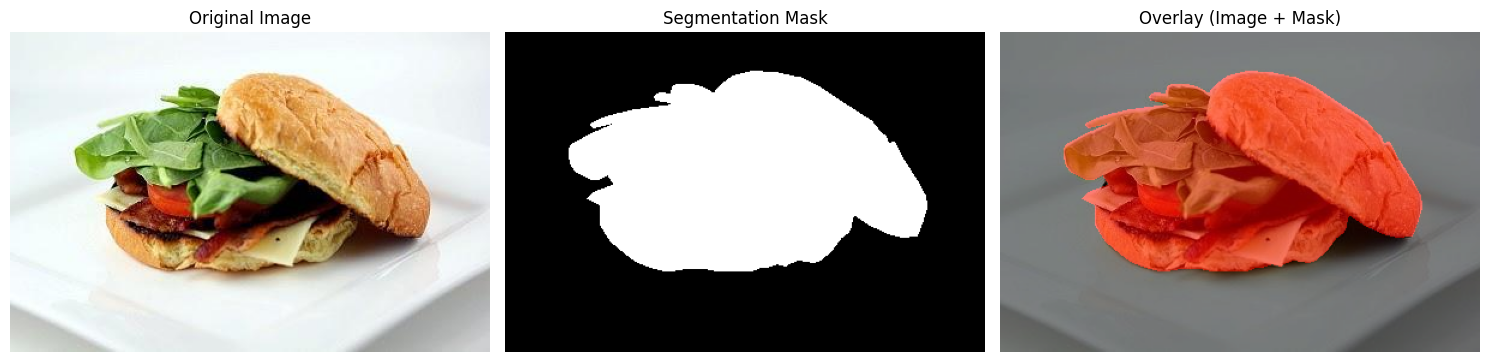

🖼️ Image Path: data/foodSeg103/val/images/189.jpg
🎭 Mask Path: data/foodSeg103/val/labels/189.png
✅ Mask Coverage: 35435 pixels (33.18% of image)


In [15]:
# Pick a random image
img_path, lbl_path = get_random_image_sample(train_img_dir, val_img_dir, seeds)
# Visualize it
visualize_image_with_mask(img_path, lbl_path)

# Experimentation

## Setup HyperParameters


In [16]:
# Get classnames from dataset's data.yaml
import yaml
from pathlib import Path

# Path to your YAML file
yaml_path = dataset_path / "data.yaml"

# Load YAML file
with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

# Extract the number of classes
num_classes = data_cfg.get("nc", None)
print(f"✅ Number of classes (nc): {num_classes}")


✅ Number of classes (nc): 104


In [17]:
import pandas as pd

# Recommended ViT configuration for FoodSeg103
BATCH_SIZE = 32               # use 16 if GPU memory < 12GB
EPOCHS = 80                   # ViTs need longer training
LEARNING_RATE = 5e-5          # use AdamW with cosine decay
PATCH_SIZE = 16               # balanced spatial resolution and performance
NUM_CLASSES = num_classes
IMAGE_SIZE = 224              # typical for DeiT/VIT
CHANNELS = 3
EMBED_DIM = 512               # good tradeoff for segmentation
DEPTH = 8                     # moderately deep
MLP_DIM = EMBED_DIM*4         # 4× embed_dim (common rule)
DROP_RATE = 0.1
HEADS = 12                    #

# --- Display them in a column using pandas ---
df_params = pd.DataFrame({
    "Parameter": [
        "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATCH_SIZE",
        "NUM_CLASSES", "IMAGE_SIZE", "CHANNELS", "EMBED_DIM",
        "DEPTH", "MLP_DIM", "DROP_RATE", "HEADS"
    ],
    "Value": [
        BATCH_SIZE, EPOCHS, LEARNING_RATE, PATCH_SIZE,
        NUM_CLASSES, IMAGE_SIZE, CHANNELS, EMBED_DIM,
        DEPTH, MLP_DIM, DROP_RATE, HEADS
    ]
})

display(df_params.set_index("Parameter").T)

Parameter,BATCH_SIZE,EPOCHS,LEARNING_RATE,PATCH_SIZE,NUM_CLASSES,IMAGE_SIZE,CHANNELS,EMBED_DIM,DEPTH,MLP_DIM,DROP_RATE,HEADS
Value,32.0,80.0,0.00005,16.0,104.0,224.0,3.0,512.0,8.0,2048.0,0.1,12.0


## Prepare Dataset, Dataloaders & Transforms

### Setup Transforms

Image Transforms are necessary as it :
1. Helps the model to converge faster
2. Helps to make the numerical computations stable.

In [18]:
from torchvision import transforms

# Image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Setup Dataset

Load the dataset images as Pytorch Dataset.

In [19]:
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
from pathlib import Path

class FoodSeg103Dataset(VisionDataset):
    def __init__(self, img_dir, lbl_dir, train=False, transform=None):
        """
        Custom dataset for FoodSeg103.

        Args:
            img_dir (str or Path): Path to image directory
            lbl_dir (str or Path): Path to label directory
            train (bool): Whether this dataset is for training
            transform (callable, optional): Transform to apply on images
        """
        super().__init__(img_dir, transform=transform)
        self.img_dir = Path(img_dir)
        self.lbl_dir = Path(lbl_dir)
        self.train = train
        self.transform = transform

        # Match images and labels by filename
        self.images = sorted(list(self.img_dir.glob("*.jpg"))) + sorted(list(self.img_dir.glob("*.png")))
        self.labels = sorted(list(self.lbl_dir.glob("*.png")))

        assert len(self.images) == len(self.labels), \
        f"Image and label count mismatch! ({len(self.images)} vs {len(self.labels)})"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = Image.open(self.labels[idx]).convert("L")  # single-channel label mask

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor (no normalization)
        label = transforms.PILToTensor()(label).squeeze(0).long()

        return image, label


    def __repr__(self):
        """Pretty-print like torchvision.datasets"""
        split = "Train" if self.train else "Validation"
        transform_str = self.transform.__repr__().replace("\n", "\n    ") if self.transform else "None"

        return (
            f"Dataset FoodSeg103\n"
            f"    Number of datapoints: {len(self)}\n"
            f"    Root location: {self.img_dir.parent}\n"
            f"    Split: {split}\n"
            f"    StandardTransform\n"
            f"Transform: {transform_str}\n"
        )

In [20]:
train_dataset = FoodSeg103Dataset(
    img_dir=train_img_dir,
    lbl_dir=train_lbl_dir,
    train=True,
    transform=transform
)

val_dataset = FoodSeg103Dataset(
    img_dir=val_img_dir,
    lbl_dir=val_lbl_dir,
    train=False,
    transform=transform
)
print(f"Length of train_dataset: {len(train_dataset.images)}")
print(f"Length of val_dataset: {len(val_dataset.images)}")

Length of train_dataset: 4983
Length of val_dataset: 2135


In [21]:
train_dataset

Dataset FoodSeg103
    Number of datapoints: 4983
    Root location: data/foodSeg103/train
    Split: Train
    StandardTransform
Transform: Compose(
        RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
        ToTensor()
        Normalize(mean=[0.5], std=[0.5])
    )

In [22]:
val_dataset

Dataset FoodSeg103
    Number of datapoints: 2135
    Root location: data/foodSeg103/val
    Split: Validation
    StandardTransform
Transform: Compose(
        RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
        ToTensor()
        Normalize(mean=[0.5], std=[0.5])
    )

### Setup Dataloaders

Dataloaders turns our data into mini batches. It is more computaionally efficient to work with small chunks of data rather than the entire dataset.

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers
)

print(f"Data: {len(train_dataset.images), len(val_dataset.images)}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} samples")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE} samples")

Data: (4983, 2135)
Length of train_dataloader: 156 batches of 32 samples
Length of val_dataloader: 67 batches of 32 samples


## Implement SAM Model

We are implementing the **Segment Anything Model** ([SAM](https://segment-anything.com/)) developed by **Meta AI** for universal image segmentation.

---

### 🧠 Overview

SAM is a foundation model designed to **segment any object in any image** with minimal or zero additional training.  
It generalizes to new visual concepts and scenes without task-specific fine-tuning.

The model combines an image encoder, a prompt encoder, and a mask decoder to produce segmentation masks based on different input prompts (e.g., points, bounding boxes, or text).

---

### ⚙️ How It Works

1. **Image Encoding**  
   The input image is passed through a **Vision Transformer (ViT)**–based image encoder, which converts it into a high-dimensional embedding space.

2. **Prompt Encoding**  
   The user provides prompts such as **bounding boxes**, **points**, or **text**, which are independently encoded into vector embeddings by the prompt encoder.

3. **Feature Fusion**  
   The encoded image and prompt embeddings are combined to create a contextual representation of the target object.

4. **Mask Decoding**  
   The combined representation is processed by a lightweight **mask decoder**, which outputs binary segmentation masks corresponding to the prompted objects.

---

### 🧩 Architecture Components

| Component | Description |
|------------|-------------|
| **Image Encoder** | A **ViT-based backbone** that encodes the entire image into dense feature maps. |
| **Prompt Encoder** | Encodes user prompts (points, boxes, text) into embeddings aligned with the image space. |
| **Mask Decoder** | A **transformer-based lightweight decoder** that fuses image and prompt embeddings to predict object masks. |

![SAM Workflow](https://imgs.search.brave.com/NG2iiHkKrl4dnvKaIpsxvTiqPZxjs-ALTlQl-4T_T_w/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9wcmV2/aWV3LnJlZGQuaXQv/bWV0YXMtc2VnbWVu/dC1hbnl0aGluZy1t/b2RlbC1hcmNoaXRl/Y3R1cmUtaXMtYS1n/YW1lLWNoYW5nZXIt/djAtbmc3bDF4b3Qx/ZWlkMS5wbmc_d2lk/dGg9OTMzJmZvcm1h/dD1wbmcmYXV0bz13/ZWJwJnM9NmI3NzNl/YzFmMzU4MWUxZDUw/ZGNkNjZjZTNlMWE4/NTdlMDk4ZDBkZg)

---

### 🧪 Fine-Tuning Strategy

For domain-specific tasks like **food segmentation**, we fine-tune only the **Mask Decoder** using our **custom images and segmentation masks** (e.g., from *FoodSeg103*).  

- The **image encoder** remains frozen to retain SAM’s general segmentation capability.  
- The **mask decoder** adapts SAM’s predictions to the unique textures and lighting conditions of food images.  

If ground-truth bounding boxes are not available, they can be automatically generated using **YOLO v12**, and then used as input prompts for SAM.

---

### 💡 Summary

| Step | Description |
|------|-------------|
| 1 | Encode the input image using ViT (image encoder). |
| 2 | Encode prompts (bounding boxes or points) using the prompt encoder. |
| 3 | Fuse both embeddings to generate object-specific context. |
| 4 | Decode and output segmentation masks using the mask decoder. |

In [24]:
from pathlib import Path

# Setup path to mdodels folder
model_path = Path("model/")
model_path.mkdir(parents=True, exist_ok=True)

### Download Model Checkpoint

In [25]:
import requests
from pathlib import Path
from tqdm import tqdm

# Define paths
model_type = "vit_h"
checkpoint_name = f"sam_{model_type}_4b8939.pth"
checkpoint_path = model_path / checkpoint_name

# Download only if not already present
if checkpoint_path.exists():
    print(f"✅ Checkpoint already exists: {checkpoint_path}")
else:
    url = f"https://dl.fbaipublicfiles.com/segment_anything/{checkpoint_name}"
    print(f"⬇️ Downloading {checkpoint_name} ...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    # Write with tqdm progress bar
    with open(checkpoint_path, "wb") as f, tqdm(
        desc="Downloading SAM checkpoint",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        ncols=100
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    print(f"\n✅ Download complete: {checkpoint_path}")

✅ Checkpoint already exists: model/sam_vit_h_4b8939.pth


### Load SAM Model

In [31]:
from segment_anything import sam_model_registry

sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
print(f"✅ SAM Model {model_type} is loaded from {checkpoint_path} to device {device}")

✅ SAM Model vit_h is loaded from model/sam_vit_h_4b8939.pth to device cuda


### Automatic Mask Generation

To run automatic mask genertation we need to provide a SAM Model to the `SamAutomaticMaskGenerator` class.

Set the device on **CUDA** for this task

In [33]:
from segment_anything import SamAutomaticMaskGenerator

mask_gen = SamAutomaticMaskGenerator(sam)
print("Created Mask Generator with SAM")

Created Mask Generator with SAM


#### Generate A Mask for a Random Image Sample

In [34]:
img_path, _ = get_random_image_sample(train_img_dir, val_img_dir, seeds)
img_path

PosixPath('data/foodSeg103/val/images/189.jpg')

In [37]:
import cv2

# --- Load the RGB image ---
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"Loaded Image {img_path}")

# Mask
print("Generating Image Mask ...")
mask_result = mask_gen.generate(img_rgb)
mask_result

Loaded Image data/foodSeg103/val/images/189.jpg
Generating Image Mask ...


[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 12552,
  'bbox': [172, 35, 177, 135],
  'predicted_iou': 1.0123510360717773,
  'point_coords': [[306.25, 154.359375]],
  'stability_score': 0.9891476631164551,
  'crop_box': [0, 0, 400, 267]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 24715,
  'bbox': [0, 1, 399

#### Visualize Result with Supervison

Annotating Image...


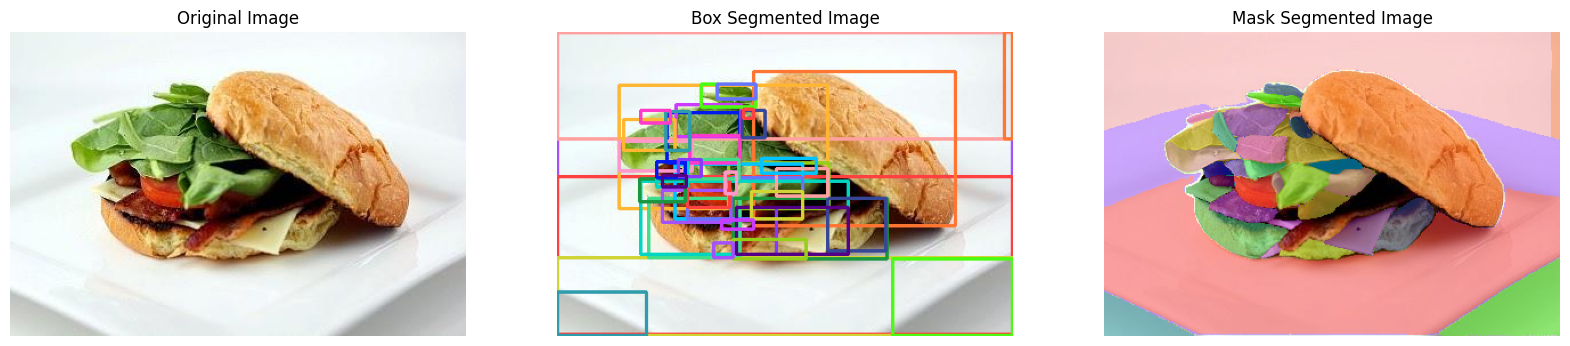

In [44]:
import supervision as sv

# Create the mask annotator (color by index)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM result into Supervision detections
detections = sv.Detections.from_sam(sam_result=mask_result)

print("Annotating Image...")
annotated_image_box = box_annotator.annotate(
    scene=img.copy(),
    detections=detections
)
annotated_image_mask = mask_annotator.annotate(
    scene=img.copy(),
    detections=detections
)


# Plot the result
sv.plot_images_grid(
    images=[img, annotated_image_box, annotated_image_mask],
    grid_size=(1, 3),
    titles=["Original Image", "Box Segmented Image", "Mask Segmented Image"],
    size=(20, 10)
)
